# Libraries

In [1]:
import numpy as np
import pandas as pd 

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import keras
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from keras import Input, Model
from keras.applications import MobileNet, ResNet50

# Config

In [3]:
main_path   = '/kaggle/input/plant-pathology-2020-fgvc7/'
batch_size  = 128
image_size  = 224
epochs      = 50
val_rate    = 0.1
bn_momentum = 0.9

# Utilities

In [4]:
def plot_batch(batch):
    fig, axs = plt.subplots(4, 4, figsize=(15,10))
    
    for i in range(4):
        for j in range(4):
            img   = batch[0][i*4 + j]
            axs[i, j].imshow(img)
            
    plt.show()
    
def plot_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(15,5))
    
    axs[0].plot(history['loss'],     label = 'train_loss')
    axs[0].plot(history['val_loss'], label = 'val_loss')
    axs[0].legend()
    axs[1].plot(history['categorical_accuracy'],     label = 'train_acc')
    axs[1].plot(history['val_categorical_accuracy'], label = 'val__acc')
    axs[1].legend()
    
    
    plt.show()

# Train and Validation Data

In [5]:
train_df = pd.read_csv(main_path + 'train.csv')
train_df['image_id']                                  = train_df['image_id'] + '.jpg'
train_df['y_col']                                     = train_df['image_id']
train_df['y_col'][train_df['healthy'] == 1]           = 'healthy'
train_df['y_col'][train_df['multiple_diseases'] == 1] = 'multiple_diseases'
train_df['y_col'][train_df['rust'] == 1]              = 'rust'
train_df['y_col'][train_df['scab'] == 1]              = 'scab'
train_df

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: Se

,image_id,healthy,multiple_diseases,rust,scab,y_col
0,Train_0.jpg,0,0,0,1,scab
1,Train_1.jpg,0,1,0,0,multiple_diseases
2,Train_2.jpg,1,0,0,0,healthy
3,Train_3.jpg,0,0,1,0,rust
4,Train_4.jpg,1,0,0,0,healthy
...,...,...,...,...,...,...
1816,Train_1816.jpg,0,0,0,1,scab
1817,Train_1817.jpg,1,0,0,0,healthy
1818,Train_1818.jpg,1,0,0,0,healthy
1819,Train_1819.jpg,0,0,1,0,rust


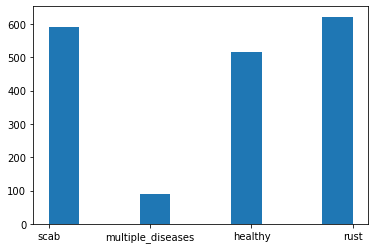

In [6]:
plt.hist(train_df['y_col'])
plt.show()

In [7]:
data_gen = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    vertical_flip = True,
    validation_split=val_rate
)

train = data_gen.flow_from_dataframe(
    train_df,
    directory = main_path + 'images',
    x_col = 'image_id',
    y_col = 'y_col',
    class_mode = 'categorical',
    target_size=(image_size, image_size),
    batch_size = batch_size,
    shuffle = True,
    subset="training",
)

val = data_gen.flow_from_dataframe(
    train_df,
    directory = main_path + 'images',
    x_col = 'image_id',
    y_col = 'y_col',
    class_mode = 'categorical',
    target_size=(image_size, image_size),
    batch_size = batch_size,
    shuffle = False,
    subset="validation",
)

Found 1639 validated image filenames belonging to 4 classes.
Found 182 validated image filenames belonging to 4 classes.


In [8]:
classes = train.class_indices
classes

{'healthy': 0, 'multiple_diseases': 1, 'rust': 2, 'scab': 3}

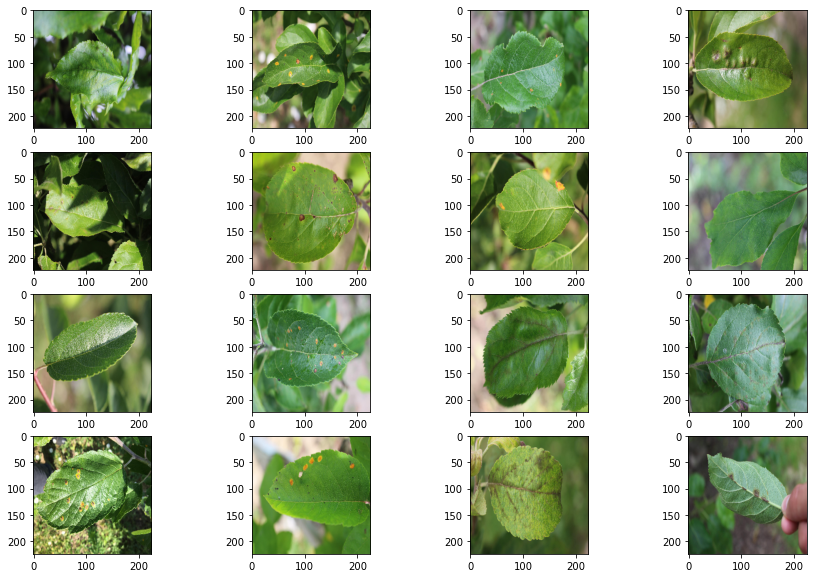

In [9]:
for batch in train:
    plot_batch(batch)
    break

# Model

In [10]:
inputs = Input(shape = (image_size, image_size, 3))

model = ResNet50(
    weights = None,
    classes = 4
)

model.compile(optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy']
)

for layer in model.layers:
    if layer.name.split('_')[-1] == 'bn':
        layer.momentum = bn_momentum

In [11]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

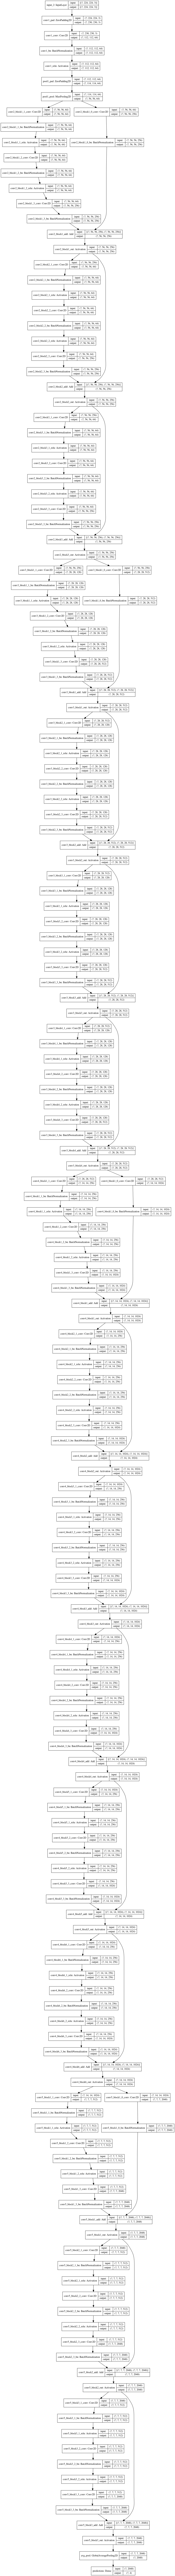

In [12]:
keras.utils.plot_model(model, show_shapes=True, expand_nested=True)

In [13]:
history = model.fit(
    train,
    epochs=epochs,
    validation_data = val
)

Epoch 1/50
13/13 [==============================] - 70s 5s/step - loss: 2.5713 - categorical_accuracy: 0.3819 - val_loss: 3.5393 - val_categorical_accuracy: 0.3736
Epoch 2/50
13/13 [==============================] - 61s 5s/step - loss: 1.1986 - categorical_accuracy: 0.4710 - val_loss: 2.2426 - val_categorical_accuracy: 0.3736
Epoch 3/50
13/13 [==============================] - 60s 5s/step - loss: 1.1075 - categorical_accuracy: 0.5180 - val_loss: 1.9311 - val_categorical_accuracy: 0.2418
Epoch 4/50
13/13 [==============================] - 61s 5s/step - loss: 1.0442 - categorical_accuracy: 0.5516 - val_loss: 1.4543 - val_categorical_accuracy: 0.3187
Epoch 5/50
13/13 [==============================] - 61s 5s/step - loss: 0.9518 - categorical_accuracy: 0.6010 - val_loss: 1.1026 - val_categorical_accuracy: 0.5495
Epoch 6/50
13/13 [==============================] - 61s 5s/step - loss: 0.8791 - categorical_accuracy: 0.6315 - val_loss: 1.0209 - val_categorical_accuracy: 0.5330
Epoch 7/50
13/13

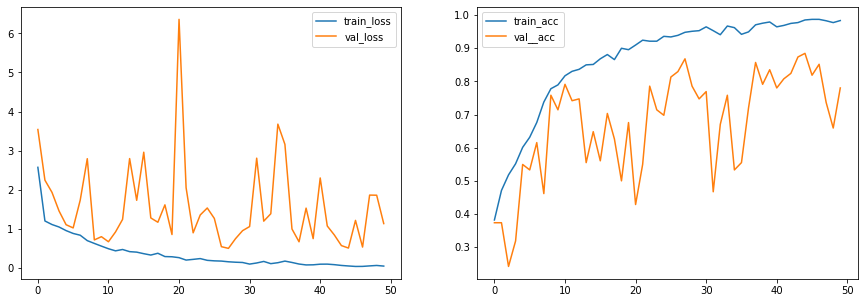

In [14]:
plot_history(history.history)

# Submit

In [15]:
submit = pd.read_csv(main_path + 'sample_submission.csv')
submit['filename'] = submit['image_id'] + '.jpg'
submit

,image_id,healthy,multiple_diseases,rust,scab,filename
0,Test_0,0.25,0.25,0.25,0.25,Test_0.jpg
1,Test_1,0.25,0.25,0.25,0.25,Test_1.jpg
2,Test_2,0.25,0.25,0.25,0.25,Test_2.jpg
3,Test_3,0.25,0.25,0.25,0.25,Test_3.jpg
4,Test_4,0.25,0.25,0.25,0.25,Test_4.jpg
...,...,...,...,...,...,...
1816,Test_1816,0.25,0.25,0.25,0.25,Test_1816.jpg
1817,Test_1817,0.25,0.25,0.25,0.25,Test_1817.jpg
1818,Test_1818,0.25,0.25,0.25,0.25,Test_1818.jpg
1819,Test_1819,0.25,0.25,0.25,0.25,Test_1819.jpg


In [16]:
test_data_gen = ImageDataGenerator(
    rescale = 1./255, 
)

test = test_data_gen.flow_from_dataframe(
    submit,
    directory = main_path + 'images',
    x_col = 'filename',
    class_mode = None,
    target_size=(image_size, image_size),
    batch_size = batch_size,
    shuffle = False,
)

Found 1821 validated image filenames.


In [17]:
predict = model.predict(test, verbose = 1)

15/15 [==============================] - 68s 5s/step


In [18]:
submit['healthy']           = predict[:, classes['healthy']]
submit['multiple_diseases'] = predict[:, classes['multiple_diseases']]
submit['rust']              = predict[:, classes['rust']]
submit['scab']              = predict[:, classes['scab']]

del submit['filename']

In [19]:
submit

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,7.324251e-17,1.631908e-08,1.000000,3.221077e-15
1,Test_1,4.294578e-12,6.480498e-04,0.999352,5.507771e-11
2,Test_2,9.970134e-01,2.725397e-03,0.000009,2.522900e-04
3,Test_3,9.999408e-01,4.019215e-05,0.000002,1.730020e-05
4,Test_4,8.375142e-18,4.968843e-06,0.999995,3.692963e-16
...,...,...,...,...,...
1816,Test_1816,6.423808e-13,2.284219e-09,1.000000,1.380975e-12
1817,Test_1817,1.579430e-05,2.764374e-03,0.000019,9.972007e-01
1818,Test_1818,6.176814e-14,2.572376e-06,0.999997,8.297943e-12
1819,Test_1819,9.998698e-01,4.904368e-06,0.000061,6.415236e-05


In [20]:
submit.to_csv("submission.csv", index=False)